프로젝트: Vocabulary Size를 변경해서 뉴스 카테고리 다중분류 시도해보기
=== 

뉴스 텍스트의 주제를 분류하는 태스크를 다양한 기법으로 다시 시도해 보고 어떤 방법이 가장 우수한 성능을 보이는지 실험해 본다.
     
중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.
     
사용할 모델 : 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅
    
    
[ 목차 ]
1. 모든 단어 사용
2. 빈도수 상위 5,000개의 단어만 사용
3. 직접 단어 개수를 설정해서 사용
4. 딥러닝 모델과 비교해 보기

# 로이터 뉴스 데이터

우리가 사용할 데이터는 로이터 뉴스 데이터입니다. 이 데이터는 총 46개의 클래스로 구성되며, 해당 뉴스가 어느 카테고리에 속하는지를 예측하기 위한 데이터입니다. 텐서플로우 데이터셋에서 제공하고 있는 데이터로 아주 쉽게 다운로드가 가능합니다. 
- tf.keras.datasets.reuters.load_data(num_words)  
    num_words :	(integer or None)      
    Words are ranked by how often they occur and only the num_words most frequent words are kept. Any less frequent word will appear as oov_char value in the sequence data.     
    If None, all words are kept. Defaults to None, so all words are kept.    
    https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data
    
num_word를 변경하며 단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해 봅니다.

In [18]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 사용할 모델 

다음의 여러 머신러닝 알고리즘을 사용해서 텍스트를 분류해 봅니다. 

- 나이브 베이즈 분류기 (Multinomial Naive Bayes Classifier)    
    https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- CNB (Complement Naive Bayes Classifier)    
    https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html
- 로지스틱 회귀 (Logistic Regression)    
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- 서포트 벡터 머신 (Linear Support Vector Machine)    
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
- 결정 트리 (Decision Tree)    
    https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- 랜덤 포레스트 (Random Forest)    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- 그래디언트 부스팅 트리 (GradientBoostingClassifier)    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- 보팅 (Voting)    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [2]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score #정확도 계산

# 1. 모든 단어 사용

(x_train, y_train), (x_test, y_test) = reuters.load_data(**num_words=None**, test_split=0.2)

## 1.1 데이터 로드하기

텐서플로우 데이터셋으로부터 로이터 뉴스 데이터를 받아옵니다.

In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
# 데이터 구성 확인 
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


- 훈련용 뉴스는 8,982개. 그리고 테스트용 뉴스는 2,246개가 있습니다. 8:2의 비율을 가집니다.
    
첫 번째 훈련용 뉴스와 첫 번째 테스트용 뉴스를 출력해 봅니다.

In [5]:
print(x_train[0])
print(x_test[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 192,

In [6]:
# 레이블 출력
print(y_train[0])
print(y_test[0])

3
3


In [7]:
# 클래스수 확인   
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


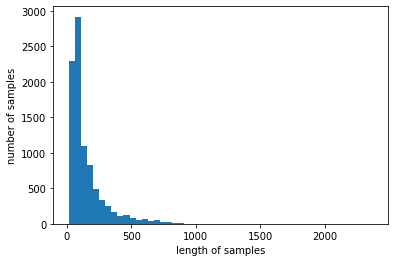

In [8]:
# 데이터 분포 확인
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

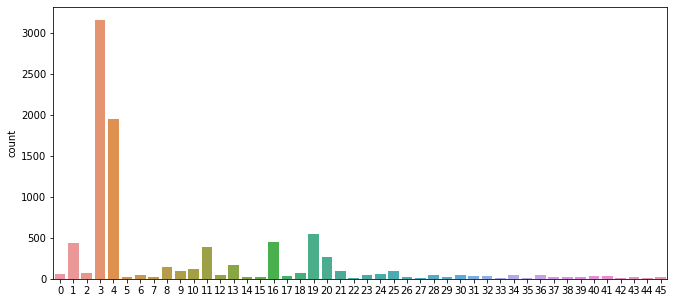

In [9]:
# 클래스 분포 확인 - 그래프
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [10]:
# 클래스 분포 확인 - 수치
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


## 1.2 데이터 복원하기

정수 시퀀스로 변환된 데이터를 원본 뉴스 데이터인 텍스트로 돌려봅니다.

In [11]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

557056/550378 [==============================] - 0s 0us/step


- 로이터 뉴스 데이터는 '단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary를 제공합니다. reuters.get_word_index()에서 얻는 숫자보다 +3을 해야 실제 맵핑되는 정수입니다. 이건 로이터 뉴스 데이터가 정의한 일종의 약속입니다.
- tf.keras.datasets.reuters.get_word_index() : Retrieves a dict mapping words to their index in the Reuters dataset    
    https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/get_word_index
  

In [12]:
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [13]:
# 첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


- 잘 복원된 것을 확인할 수 있습니다.

이제 전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환해 봅니다.

In [46]:
# 데이터 복원 
def convert2text(data):
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)

    return decoded

In [14]:
# train 데이터 복원 
x_train = convert2text(x_train)
print(len(x_train))

8982


In [15]:
# test 데이터 복원 
x_test = convert2text(x_test)
print(len(x_test))

2246


In [16]:
x_train[:2]

['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3"]

In [17]:
x_test[:2]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arsenio yulo said yu

- 제대로 변환이 되었는지 확인할 수 있습니다. 

## 1.3 벡터화 하기

텍스트 데이터가 있을 때, 모델의 입력으로 넣기 위해서는 우선 각 문서를 벡터화할 필요가 있습니다. 벡터화 방법은 Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬을 사용합니다. 
- DTM은 사이킷런의 CountVectorizer()를 통해서 생성할 수 있습니다.
- TF-IDF Matrix는 사이킷런의 TfidfTransformer()를 통해서 생성할 수 있습니다. 

In [19]:
# DTM 생성 
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [20]:
# TF-IDF 행렬 생성 
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


테스트 데이터에 대한 정확도를 측정하기 위해서는 테스트 데이터도 훈련 데이터와 동일한 전처리를 거쳐야 합니다. 

In [22]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
print(x_test_dtm.shape)
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
print(tfidfv_test.shape)

(2246, 26506)
(2246, 26506)


## 1.4 머신러닝 모델 적용 

### 1) 나이브 베이즈 분류기(Multinomial Naive Bayes Classifier)

나이브 베이즈 분류기는 사이킷런의 MultinomialNB()를 통해 사용할 수 있습니다.

In [25]:
mnb = MultinomialNB()
mnb.fit(tfidfv, y_train)

MultinomialNB()

In [26]:
predicted = mnb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.5997328584149599


### 2) Complement Naive Bayes Classifier(CNB)

In [27]:
cnb = ComplementNB()
cnb.fit(tfidfv, y_train)

ComplementNB()

In [28]:
predicted = cnb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


### 3) 로지스틱 회귀(Logistic Regression)

In [29]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000)

In [30]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.813446126447017


### 4) 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [31]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [32]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7867319679430098


### 5) 결정 트리(Decision Tree)

In [33]:
dtree = DecisionTreeClassifier(max_depth=10, random_state=0)
dtree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [34]:
predicted = dtree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


### 6) 랜덤 포레스트(Random Forest)

In [35]:
rdforest = RandomForestClassifier(n_estimators=5, random_state=0)
rdforest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [36]:
predicted = rdforest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


### 7) 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [38]:
grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [39]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


### 8) 보팅(Voting)

In [40]:
vt_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
vt_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [41]:
predicted = vt_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8187889581478184


# 2. 빈도수 상위 5,000개의 단어만 사용

(x_train, y_train), (x_test, y_test) = reuters.load_data(**num_words=5000**, test_split=0.2)

## 2.1 데이터 로드하기

In [43]:
(x_train2, y_train2), (x_test2, y_test2) = reuters.load_data(num_words=5000, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


## 2.2 데이터 복원하기

In [44]:
index_to_word

{10999: 'mdbl',
 16263: 'fawc',
 12092: 'degussa',
 8806: 'woods',
 13799: 'hanging',
 20675: 'localized',
 20676: 'sation',
 20678: 'chanthaburi',
 11000: 'refunding',
 8807: 'hermann',
 20679: 'passsengers',
 20680: 'stipulate',
 8355: 'heublein',
 20716: 'screaming',
 16264: 'tcby',
 188: 'four',
 1645: 'grains',
 20683: 'broiler',
 12093: 'wooden',
 1223: 'wednesday',
 13800: 'highveld',
 7596: 'duffour',
 20684: '0053',
 3917: 'elections',
 2566: '270',
 3554: '271',
 5116: '272',
 3555: '273',
 3403: '274',
 7978: 'rudman',
 3404: '276',
 3481: '277',
 3635: '278',
 4312: '279',
 9384: 'dormancy',
 7250: 'errors',
 3089: 'deferred',
 20686: 'sptnd',
 8808: 'cooking',
 20687: 'stratabit',
 16265: 'designing',
 20688: 'metalurgicos',
 13801: 'databank',
 20689: '300er',
 20690: 'shocks',
 7975: 'nawg',
 20691: 'tnta',
 20692: 'perforations',
 2894: 'affiliates',
 20693: '27p',
 16266: 'ching',
 598: 'china',
 16267: 'wagyu',
 3192: 'affiliated',
 16268: 'chino',
 16269: 'chinh',
 2

In [47]:
# train 데이터 복원 
x_train2 = convert2text(x_train2)
print(len(x_train2))

8982


In [48]:
# test 데이터 복원 
x_test2 = convert2text(x_test2)
print(len(x_test2))

2246


## 2.3 벡터화 하기

In [49]:
## train data 
# DTM 생성 
#dtmvector = CountVectorizer()
x_train2_dtm = dtmvector.fit_transform(x_train2)
print(x_train2_dtm.shape)

# TF-IDF 행렬 생성 
#tfidf_transformer = TfidfTransformer()
tfidfv2 = tfidf_transformer.fit_transform(x_train2_dtm)
print(tfidfv2.shape)

(8982, 4867)
(8982, 4867)


In [50]:
## test data 
# DTM으로 변환
x_test2_dtm = dtmvector.transform(x_test2) 
print(x_test2_dtm.shape)

# DTM을 TF-IDF 행렬로 변환
tfidfv_test2 = tfidf_transformer.transform(x_test2_dtm) 
print(tfidfv_test2.shape)

(2246, 4867)
(2246, 4867)


## 2.4 머신러닝 모델 적용

### 1) 나이브 베이즈 분류기(Multinomial Naive Bayes Classifier)

In [51]:
#mnb = MultinomialNB()
mnb.fit(tfidfv2, y_train2)
predicted = mnb.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.6731967943009796


### 2) Complement Naive Bayes Classifier(CNB)

In [52]:
#cnb = ComplementNB()
cnb.fit(tfidfv2, y_train2)
predicted = cnb.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


### 3) 로지스틱 회귀(Logistic Regression)

In [53]:
#lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv2, y_train2)
predicted = lr.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.8058771148708815


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 4) 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [54]:
#lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv2, y_train2)
predicted = lsvc.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.763579697239537


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### 5) 결정 트리(Decision Tree)

In [55]:
#dtree = DecisionTreeClassifier(max_depth=10, random_state=0)
dtree.fit(tfidfv2, y_train2)
predicted = dtree.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.6179875333926982


### 6) 랜덤 포레스트(Random Forest)


In [56]:
#rdforest = RandomForestClassifier(n_estimators=5, random_state=0)
rdforest.fit(tfidfv2, y_train2)
predicted = rdforest.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

정확도: 0.701246660730187


### 7) 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [ ]:
#grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(tfidfv2, y_train2)
predicted = grbt.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교

### 8) 보팅(Voting)

In [ ]:
#vt_classifier = VotingClassifier(estimators=[
#         ('lr', LogisticRegression(C=10000, penalty='l2')),
#        ('cb', ComplementNB()),
#        ('grbt', GradientBoostingClassifier(random_state=0))
#], voting='soft', n_jobs=-1)
vt_classifier.fit(tfidfv2, y_train2)
predicted = vt_classifier.predict(tfidfv_test2) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test2, predicted)) #예측값과 실제값 비교